In [2]:
from modelspati import *
from data import *

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'','train','train_mask',data_gen_args,save_to_dir = None)
model = unet_with_attention()
model_checkpoint = ModelCheckpoint('unet.h5', monitor='loss',verbose=1, save_best_only=True)
model.fit(myGene,steps_per_epoch=1000,epochs=5,callbacks=[model_checkpoint])

### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results

In [5]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def predict_and_visualize_images(model_filename, image_folder, label_folder, num_images=5, target_size=(256, 256)):
    # 加载模型
    model = tf.keras.models.load_model(model_filename)

    # 列出文件夹中的所有图像文件
    image_files = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.png')]

    # 随机选择指定数量的图像
    selected_images = random.sample(image_files, num_images)

    for image_path in selected_images:
        # 读取原始图像和ground truth
        original_image = Image.open(image_path)
        ground_truth_path = os.path.join(label_folder, os.path.basename(image_path))  # 使用 ground_truth_folder 参数
        ground_truth_image = Image.open(ground_truth_path)

        # 调整图像大小为指定的目标大小
        input_image = original_image.resize(target_size)
        ground_truth_image = ground_truth_image.resize(target_size)

        input_image_array = np.array(input_image)  # 将PIL图像转换为NumPy数组
        ground_truth_array = np.array(ground_truth_image)  # 将PIL图像转换为NumPy数组
        input_image_array = np.expand_dims(input_image_array, axis=-1)  # 添加通道维度
        ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)  # 添加通道维度

        # 预测
        predictions = model.predict(np.expand_dims(input_image_array, axis=0))
        output_image = (predictions[0] * 255).astype(np.uint8)

        # 提取图像文件名（不带路径）
        image_filename = os.path.basename(image_path)

        # 保存输出图像为文件，以图像文件名命名
        #output_filename = f'unet_{image_filename}'
        #cv2.imwrite(output_filename, output_image)

        # 显示原始图像、ground truth和预测结果图像
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(input_image, cmap='gray')  # 显示原始图像
        plt.title('Original Image', fontsize=14)

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth_image, cmap='gray')  # 显示ground truth
        plt.title('Ground Truth', fontsize=14)

        plt.subplot(1, 3, 3)
        plt.imshow(output_image, cmap='gray')  # 显示预测图像
        plt.title('Predicted Image', fontsize=14)
        plt.suptitle(image_filename, fontsize=16)
        plt.show()


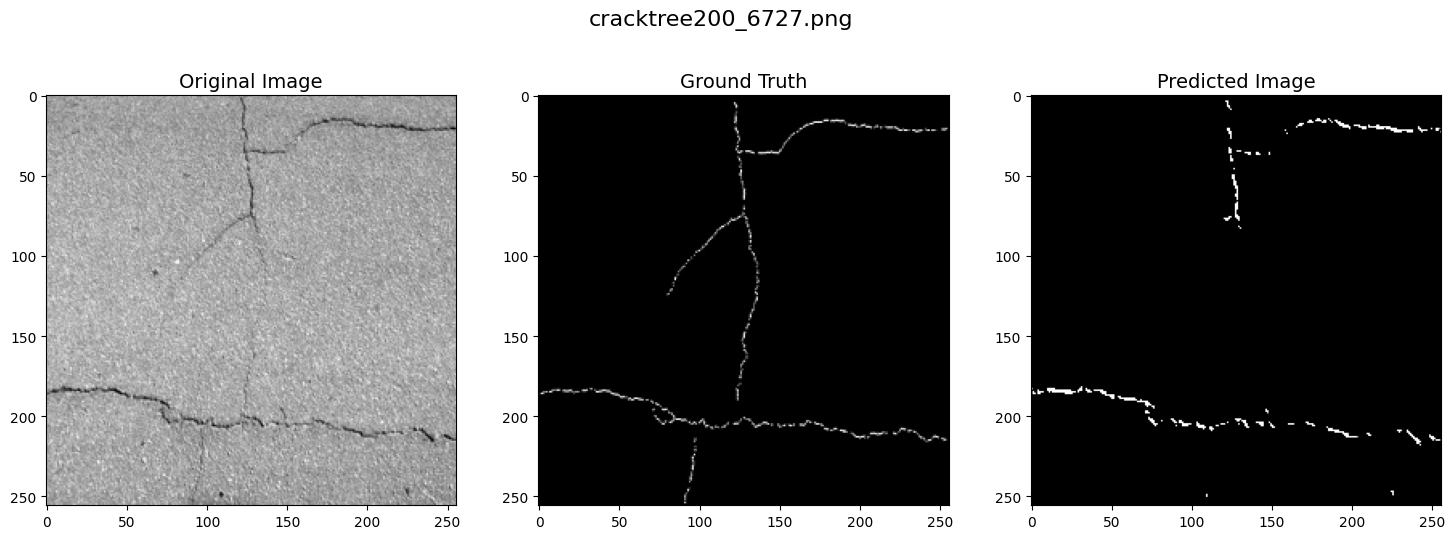

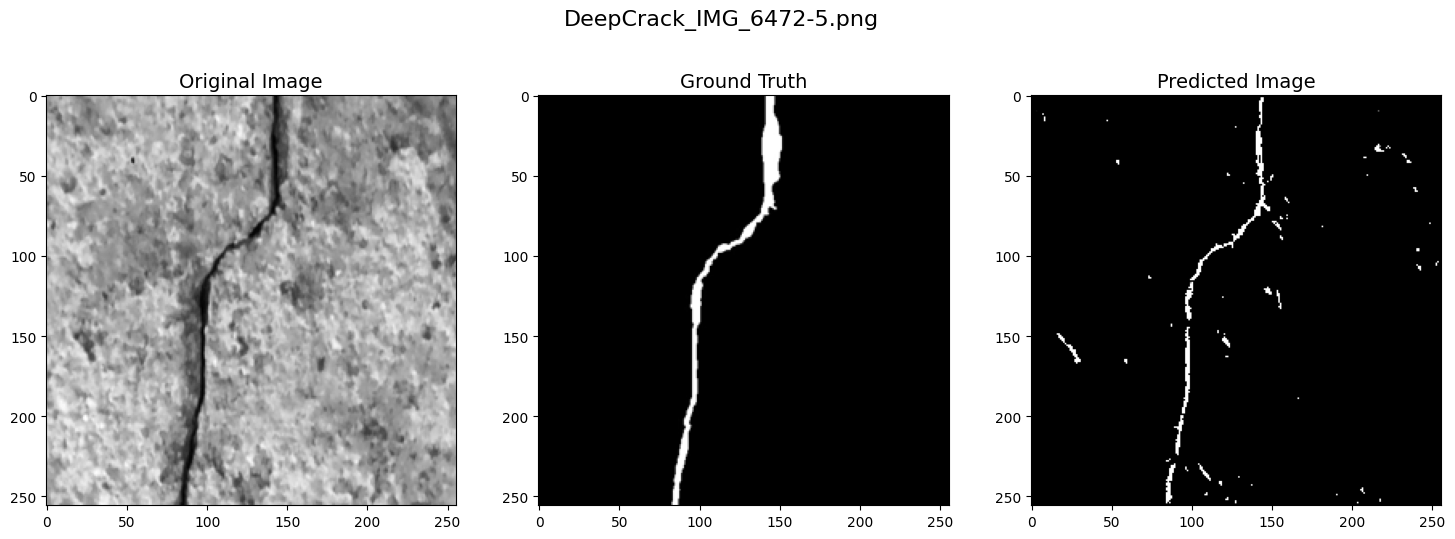

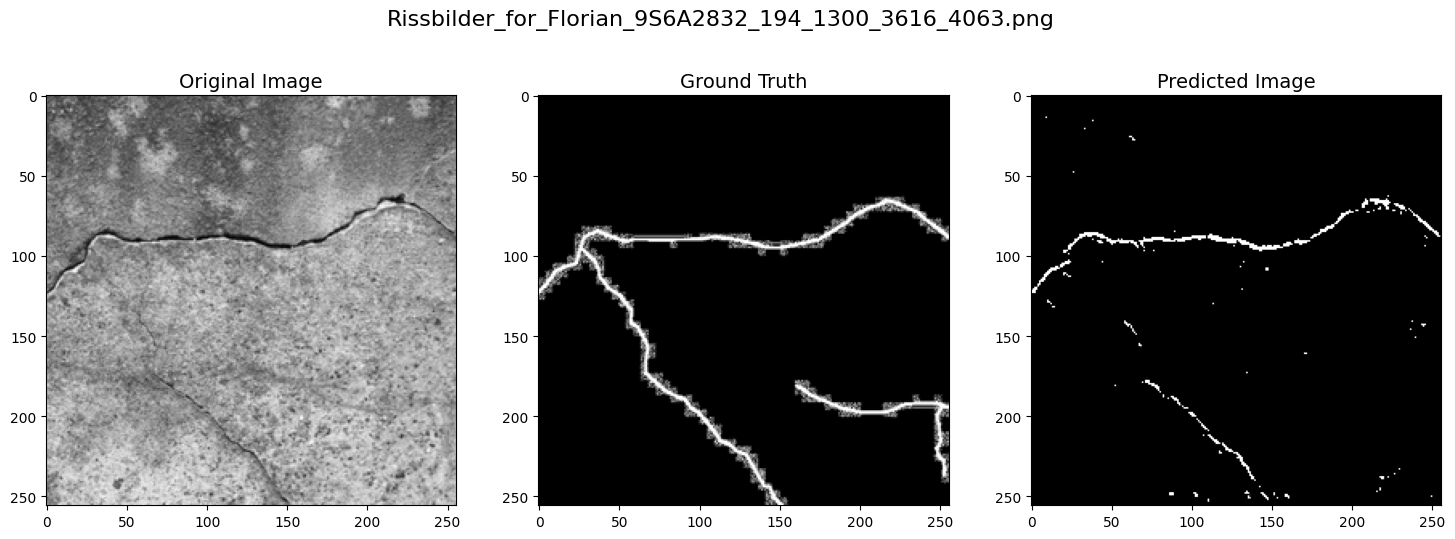

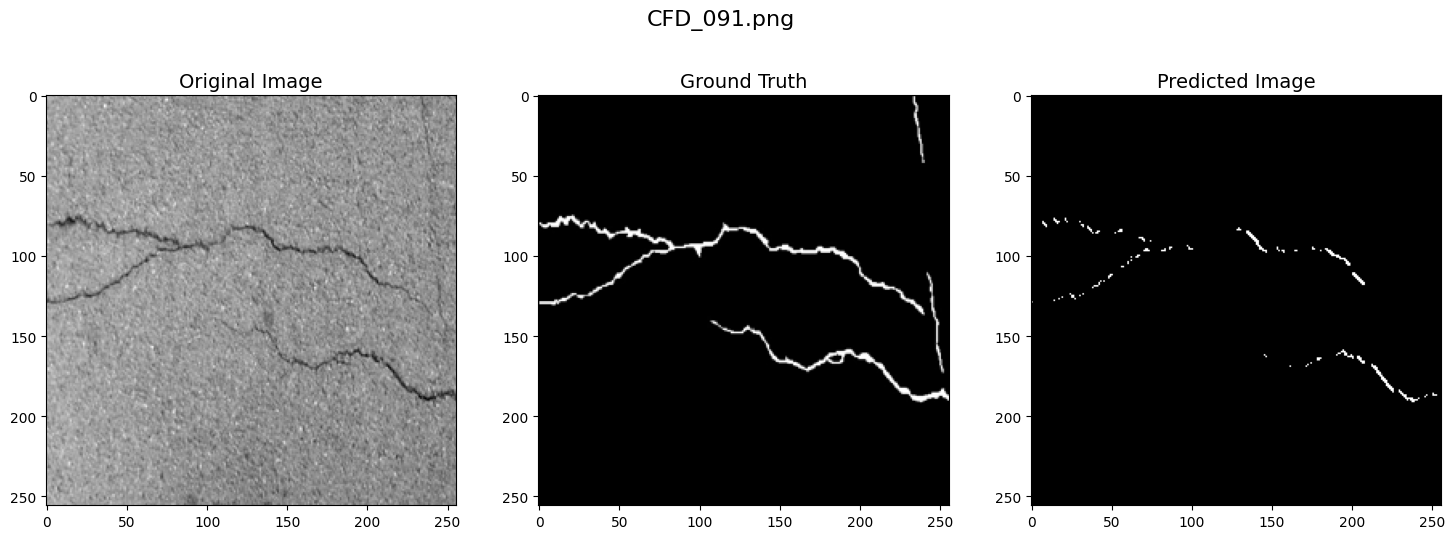

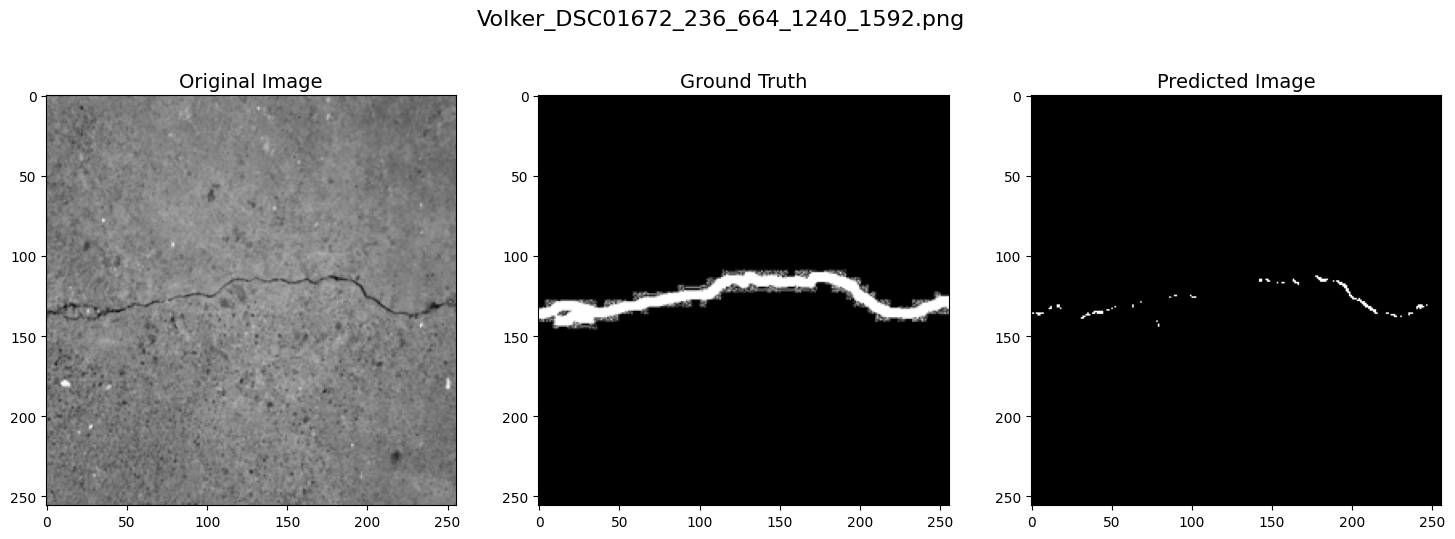

In [6]:
model_filename = 'unet.h5'
image_folder = r'd:\Users\ru83m\Desktop\Rissbilder5\test5'
label_folder =r"d:\Users\ru83m\Desktop\Rissbilder5\test5_mask"
num_images = 5
predict_and_visualize_images(model_filename, image_folder,label_folder, num_images)

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score

def predict_image(model, image_path, label_folder, target_size=(256, 256)):
        original_image = Image.open(image_path)
        ground_truth_path = os.path.join(label_folder, os.path.basename(image_path))
        ground_truth_image = Image.open(ground_truth_path)

        input_image = original_image.resize(target_size)
        ground_truth_image = ground_truth_image.resize(target_size)

        input_image_array = np.array(input_image)
        ground_truth_array = np.array(ground_truth_image)

        input_image_array = np.expand_dims(input_image_array, axis=-1)
        ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)

        predictions = model.predict(np.expand_dims(input_image_array, axis=0))
        

        return predictions, ground_truth_array

def compute_confusion_metrics(predictions, ground_truths, threshold=0.5):
    binary_predictions = (predictions > threshold).astype(np.uint8)
    binary_ground_truths = (ground_truths > 0.5).astype(np.uint8)

    confusion_mat = confusion_matrix(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Confusion Matrix:")
    print(confusion_mat)

    accuracy = accuracy_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    precision_metric = precision_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    recall = recall_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    jaccard_similarity = jaccard_score(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision_metric))
    print("Recall: {:.4f}".format(recall))
    print("Jaccard Similarity: {:.4f}".format(jaccard_similarity))

def main():
    # 加载模型
    model = tf.keras.models.load_model(model_filename)

    # 获取测试图像文件列表
    test_image_files = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.png')]

    # 初始化列表来存储所有预测和真实标签
    all_predictions = []
    all_ground_truths = []
    
    # 遍历所有测试图像并获取预测和真实标签
    for image_path in test_image_files:
        predictions, ground_truth = predict_image(model, image_path, label_folder)
        all_predictions.append(predictions)
        all_ground_truths.append(ground_truth)

    # 将列表转换为NumPy数组
    all_predictions = np.array(all_predictions)
    all_ground_truths = np.array(all_ground_truths)

    # 计算混淆矩阵和性能指标
    compute_confusion_metrics(all_predictions, all_ground_truths, threshold=0.5)

if __name__ == "__main__":
    model_filename = 'unet_spati.h5'
    image_folder = r'd:\Users\ru83m\Desktop\Rissbilder5\1'
    label_folder = r'd:\Users\ru83m\Desktop\Rissbilder5\1_mask'
    main()

Confusion Matrix:
[[63071   436]
 [ 1485   544]]
Accuracy: 0.9707
Precision: 0.5551
Recall: 0.2681
Jaccard Similarity: 0.2207


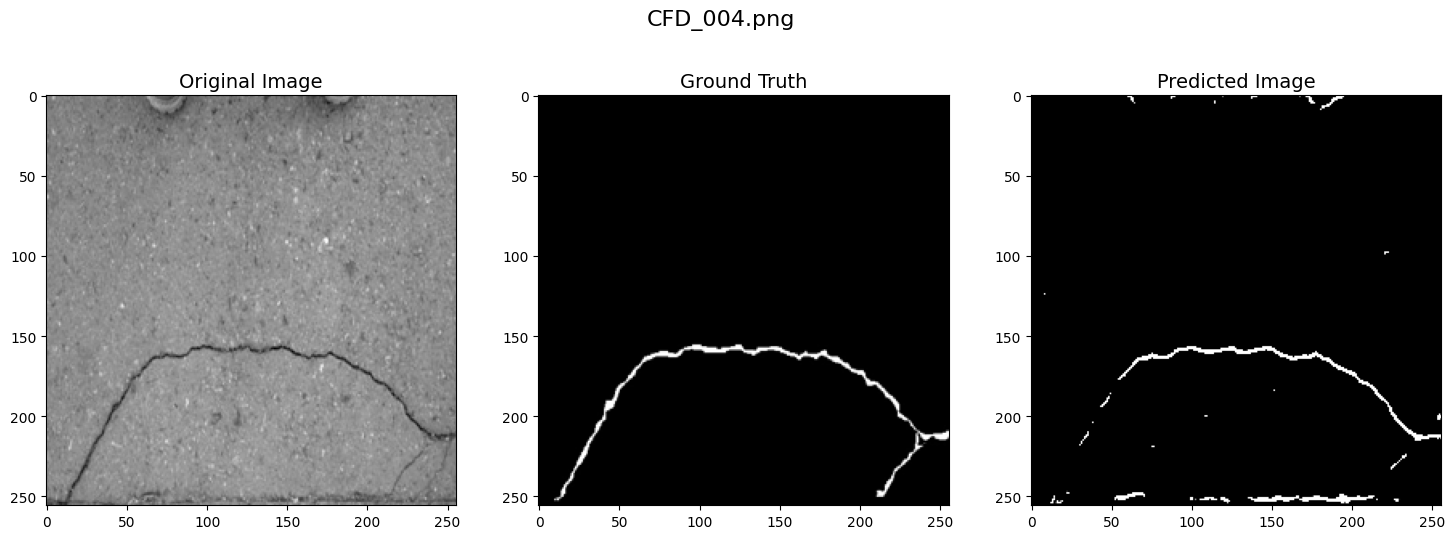

In [11]:
model_filename = 'unet_spati.h5'
image_folder = r'd:\Users\ru83m\Desktop\Rissbilder5\1'
label_folder =r'd:\Users\ru83m\Desktop\Rissbilder5\1_mask'
num_images = 1
predict_and_visualize_images(model_filename, image_folder,label_folder, num_images)

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score
from PIL import Image
import os
import tensorflow as tf
import numpy as np

# ...

@tf.function
def predict_single_image(model, input_image_array):
    return model.predict(np.expand_dims(input_image_array, axis=0))

def predict_image(model, image_path, label_folder, target_size=(256, 256)):
    original_image = Image.open(image_path)
    ground_truth_path = os.path.join(label_folder, os.path.basename(image_path))
    ground_truth_image = Image.open(ground_truth_path)

    input_image = original_image.resize(target_size)
    ground_truth_image = ground_truth_image.resize(target_size)

    input_image_array = np.array(input_image)
    ground_truth_array = np.array(ground_truth_image)

    input_image_array = np.expand_dims(input_image_array, axis=-1)
    ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)

    predictions = predict_single_image(model, input_image_array)
    
    return predictions, ground_truth_array

def compute_confusion_metrics(predictions, ground_truths, threshold=0.5):
    binary_predictions = (predictions > threshold).astype(np.uint8)
    binary_ground_truths = (ground_truths > 0.5).astype(np.uint8)

    confusion_mat = confusion_matrix(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Confusion Matrix:")
    print(confusion_mat)

    accuracy = accuracy_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    precision_metric = precision_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    recall = recall_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    jaccard_similarity = jaccard_score(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision_metric))
    print("Recall: {:.4f}".format(recall))
    print("Jaccard Similarity: {:.4f}".format(jaccard_similarity))

def main():
    # ...
    global all_predictions  # 增加這一行
    global all_ground_truths  # 增加這一行
    
    # 遍历所有测试图像并获取预测和真实标签
    for image_path in test_image_files:
        predictions, ground_truth = predict_image(model, image_path, label_folder)
        all_predictions.append(predictions)
        all_ground_truths.append(ground_truth)
    # 将列表转换为NumPy数组
    all_predictions = np.array(all_predictions)
    all_ground_truths = np.array(all_ground_truths)

    # 计算混淆矩阵和性能指标
    compute_confusion_metrics(all_predictions, all_ground_truths, threshold=0.5)

if __name__ == "__main__":
    # ...
    main()

NameError: name 'model' is not defined